In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import os
from einops import rearrange

In [17]:
import matplotlib.pyplot as plt

def show_tensor(tensor):
    """
    Visualizes a PyTorch tensor in Jupyter.
    Handles shapes: (C, H, W), (1, C, H, W), or (H, W).
    """
    # 1. Detach from graph, move to CPU
    img = tensor.detach().cpu()
    
    # 2. Remove batch dimension if present (e.g., [1, 3, 32, 32] -> [3, 32, 32])
    if img.dim() == 4:
        img = img[0]
        
    # 3. Permute dimensions from PyTorch (C, H, W) to Matplotlib (H, W, C)
    # Only permute if we have 3 dims (Channels, Height, Width)
    if img.dim() == 3 and img.size(0) in [1, 3]: 
        img = img.permute(1, 2, 0)

    # 4. Handle Grayscale vs RGB
    # If channel dim is 1, squeeze it out for clean grayscale plot
    if img.dim() == 3 and img.size(-1) == 1:
        img = img.squeeze(-1)
        plt.imshow(img, cmap='gray')
    else:
        # Clamp to [0, 1] to avoid warnings if values are slightly off
        plt.imshow(img.clamp(0, 1))
        
    plt.axis('off')
    plt.show()

In [2]:
BATCH_SIZE = 256
LEARNING_RATE = 0.002
EPOCHS = 10
BOND_DIM = 64          
CP_RANK = 16           
DROPOUT = 0.1          
PATCH_SIZE = 4  

In [3]:
def get_mnist_loaders():
    transform = transforms.Compose([
        transforms.Resize((32,32)), 
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_set = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    return train_loader, test_loader

In [4]:
train_loader, test_loader = get_mnist_loaders()

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.66MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 270kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 978kB/s]


In [16]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([256, 1, 32, 32])

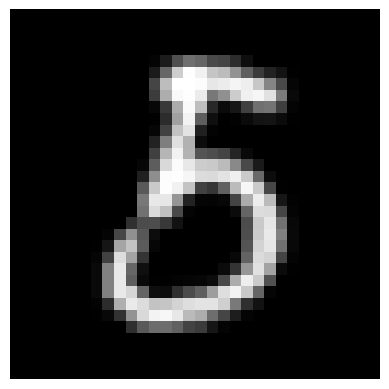

tensor(5)


In [37]:
show_tensor(images[10])
print(labels[10])

In [38]:
cnn_patch_embed = nn.Conv2d(1, BOND_DIM, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)

In [39]:
cnn_patch = cnn_patch_embed(images)
print(cnn_patch[10].shape, images[10].shape)

torch.Size([64, 8, 8]) torch.Size([1, 32, 32])


TypeError: Invalid shape (64, 8, 8) for image data

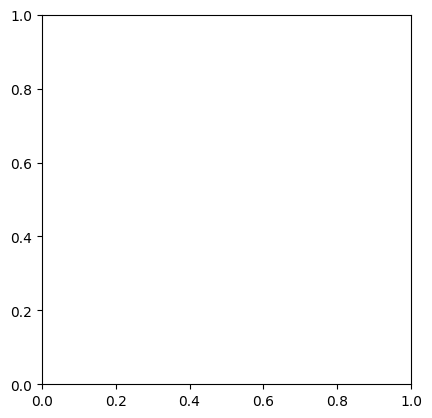

In [40]:
for i in range(cnn_patch.shape[0]):
    show_tensor(cnn_patch[1])

In [41]:
unfold_patch = nn.Unfold(kernel_size=PATCH_SIZE, stride=PATCH_SIZE)

In [42]:
unfold_patches = unfold_patch(images)
print(unfold_patches.shape)

torch.Size([256, 16, 64])


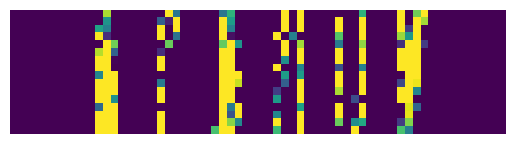

In [43]:
show_tensor(unfold_patches[10])

In [47]:
def split_to_patches(image_batch):
    # unfolded_patch = unfold_patch(images)
    maintained_patches = rearrange(images, 'b c (h p1) (w p2) -> b h w (c p1 p2)', p1=PATCH_SIZE, p2=PATCH_SIZE)
    return maintained_patches
    

In [48]:
patches = split_to_patches(images)
patches.shape

torch.Size([256, 8, 8, 16])

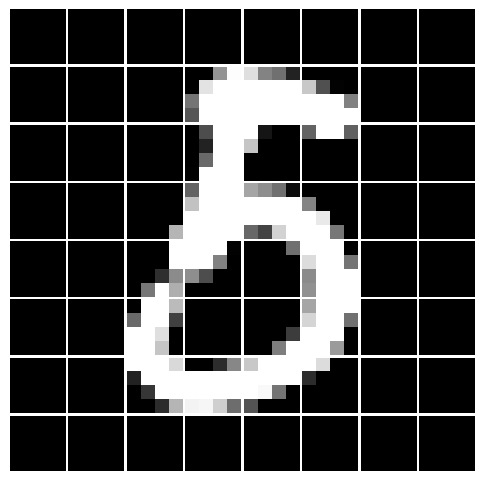

In [57]:
import matplotlib.pyplot as plt

def visualize_patch_grid(patches, patch_size=4, channels=1):
    """
    Visualizes a tensor of shape (Batch, Grid_H, Grid_W, Features)
    as a grid of small images.
    """
        
    grid_h, grid_w, _ = patches.shape
    
    # 2. Create a subplot grid that matches your patch grid (e.g., 8x8)
    fig, axes = plt.subplots(grid_h, grid_w, figsize=(6, 6))
    
    for row in range(grid_h):
        for col in range(grid_w):
            ax = axes[row, col]
            
            # 3. Extract the flat vector for this specific patch
            patch_vector = patches[row, col]
            
            # 4. Un-flatten it back to image dimensions: (C, P, P)
            patch_img = patch_vector.view(channels, patch_size, patch_size)
            
            # 5. Prep for Matplotlib: (C, H, W) -> (H, W, C)
            patch_img = patch_img.permute(1, 2, 0)
            
            # 6. Plot
            if channels == 1:
                ax.imshow(patch_img.squeeze(), cmap='gray', vmin=0, vmax=1)
            else:
                ax.imshow(patch_img.clamp(0, 1))
            
            # Hide ticks
            ax.set_xticks([])
            ax.set_yticks([])
            # Remove white borders between subplots
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)

    plt.subplots_adjust(wspace=0.05, hspace=0.05) # Tiny gap to see patch edges
    plt.show()


visualize_patch_grid(patches[10], patch_size=4, channels=1)